In [4]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# !pip install tableone
from tableone import TableOne
# !pip install psycopg2-binary
import psycopg2

In [5]:
# create a database connection
sqluser = 'postgres'
dbname = 'mimiciv'
hostname = 'localhost'
password='qwerasdf'
hosp_schema_name = 'mimiciv_hosp'

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, password=password)

In [6]:
query = \
"""
SELECT
      pat.subject_id
    , adm.hadm_id
    , DENSE_RANK() OVER hadm_window AS hosp_stay_num
    , CASE
        WHEN FIRST_VALUE(adm.hadm_id) OVER hadm_window = adm.hadm_id THEN 1
        ELSE 0
      END AS pat_count
    , pat.anchor_age + (EXTRACT(YEAR FROM adm.admittime) - pat.anchor_year) AS age
    , pat.gender
    , adm.insurance
    , mimiciv_derived.DATETIME_DIFF(adm.dischtime, adm.admittime, 'HOUR') / 24 AS hosp_los
    , pat.dod
    , mimiciv_derived.DATETIME_DIFF(pat.dod, CAST(adm.dischtime AS DATE), 'DAY') AS days_to_death
    -- mortality flags
    , CASE WHEN mimiciv_derived.DATETIME_DIFF(pat.dod, CAST(adm.dischtime AS DATE), 'DAY') = 0 THEN 1 ELSE 0 END AS hospital_mortality
FROM mimiciv_hosp.patients pat
INNER JOIN mimiciv_hosp.admissions adm
    ON pat.subject_id = adm.subject_id
WINDOW hadm_window AS (PARTITION BY pat.subject_id ORDER BY adm.admittime)
"""

hosp = pd.read_sql_query(query,con)

In [7]:
# Admission IDs with Length of Stay at least 12 hours.
hadm_id_los_geq_12h = hosp[hosp.hosp_los > 0.5].hadm_id
hadm_id_los_geq_12h

0         22595853
1         22841357
2         29079034
3         25742920
5         23052089
            ...   
431226    29734428
431227    25744818
431228    26071774
431229    21033226
431230    23865745
Name: hadm_id, Length: 392689, dtype: int64

In [8]:
adm_df = pd.read_sql_query("""
SELECT subject_id, hadm_id, admittime, dischtime FROM mimiciv_hosp.admissions
""", con)
adm_df

,subject_id,hadm_id,admittime,dischtime
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00
...,...,...,...,...
431226,19999828,25744818,2149-01-08 16:44:00,2149-01-18 17:00:00
431227,19999828,29734428,2147-07-18 16:23:00,2147-08-04 18:10:00
431228,19999840,21033226,2164-09-10 13:47:00,2164-09-17 13:42:00
431229,19999840,26071774,2164-07-25 00:27:00,2164-07-28 12:15:00


In [9]:
renal_aki = ['aki_stage_smoothed']

renal_aki_query = f"""
select icu.hadm_id,
       avg(aki_stage_smoothed) as aki_stage_smoothed,
       date_trunc('hour', r.charttime) time_bin
from mimiciv_derived.kdigo_stages as r
inner join mimiciv_icu.icustays as icu
 on icu.stay_id = r.stay_id
group by icu.hadm_id, time_bin
"""
renal_aki_df = pd.read_sql_query(renal_aki_query, con)

renal_hadm_id = pd.Series(renal_aki_df.hadm_id.unique())
adm_df['adm_has_renal_data'] = adm_df.hadm_id.isin(renal_hadm_id)

subject_has_renal = adm_df.groupby('subject_id', as_index=False).agg(n_adm=('hadm_id', 'nunique'), adm_has_renal_data=('adm_has_renal_data', 'sum'))
subjects_with_renal_info = subject_has_renal[subject_has_renal['adm_has_renal_data'] > 0]
subjects_with_renal_info['p_adm_with_renal_info'] = subjects_with_renal_info['adm_has_renal_data'] / subjects_with_renal_info['n_adm']
subject_id_with_renal_info = subjects_with_renal_info.subject_id

/tmp/ipykernel_26474/130169835.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_with_renal_info['p_adm_with_renal_info'] = subjects_with_renal_info['adm_has_renal_data'] / subjects_with_renal_info['n_adm']


In [10]:
# add 1 year mortality
hosp['one_year_mortality'] = hosp['days_to_death'].notnull().astype(int)

# create a dataframe with the days to death for only the last ICU stay
last_dod = hosp.groupby('subject_id')[['hosp_stay_num']].max().reset_index()
last_dod = last_dod.merge(hosp[['subject_id', 'hosp_stay_num', 'days_to_death']], 
                          on=['subject_id', 'hosp_stay_num'], how='inner')
last_dod.rename(columns={'days_to_death': 'days_to_death_last_stay_id'}, inplace=True)

hosp = hosp.merge(last_dod, how='left', on=['subject_id', 'hosp_stay_num'])
del last_dod
hosp.sort_values(['subject_id', 'hosp_stay_num'], inplace=True)

In [28]:
hosp = hosp.drop('insurance', axis=1)

In [29]:
hosp

,subject_id,hadm_id,hosp_stay_num,pat_count,age,gender,hosp_los,dod,days_to_death,hospital_mortality,one_year_mortality,days_to_death_last_stay_id
0,10000032,22595853,1,1,52.0,F,0.786111,2180-09-09,125.0,0,1,NaN
1,10000032,22841357,2,0,52.0,F,1.015278,2180-09-09,74.0,0,1,NaN
2,10000032,29079034,3,0,52.0,F,2.222222,2180-09-09,46.0,0,1,NaN
3,10000032,25742920,4,0,52.0,F,1.754167,2180-09-09,33.0,0,1,33.0
4,10000068,25022803,1,1,19.0,F,0.298611,None,NaN,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
431226,19999828,29734428,1,1,46.0,F,17.074306,None,NaN,0,0,NaN
431227,19999828,25744818,2,0,48.0,F,10.011111,None,NaN,0,0,NaN
431228,19999840,26071774,1,1,58.0,M,3.491667,2164-09-17,51.0,0,1,NaN
431229,19999840,21033226,2,0,58.0,M,6.996528,2164-09-17,0.0,1,1,0.0


In [12]:
# fix some data type issues
int_cols = (pd.Series(hosp.dtypes.values)=="Int64").values

In [13]:
int_cols

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [14]:
hosp.loc[:, int_cols] = hosp.loc[:, int_cols].astype(float)
hosp.loc[:, int_cols] = hosp.loc[:, int_cols].astype(int, errors="ignore")

In [15]:
query = \
"""
SELECT
      pat.subject_id
    , adm.hadm_id
    , icu.stay_id
    , ROW_NUMBER() OVER (PARTITION BY pat.subject_id ORDER BY icu.intime) AS icu_stay_num
    , DENSE_RANK() OVER (PARTITION BY pat.subject_id ORDER BY adm.admittime) AS hosp_stay_num
    , CASE
        WHEN FIRST_VALUE(icu.stay_id) OVER icustay_window = icu.stay_id THEN 1
        ELSE 0
      END AS pat_count
    , pat.anchor_age + (EXTRACT(YEAR FROM icu.intime) - pat.anchor_year) AS age
    , pat.gender
    , adm.insurance
    , icu.first_careunit
    , icu.los AS icu_los
    , mimiciv_derived.DATETIME_DIFF(adm.dischtime, adm.admittime, 'HOUR') / 24 AS hosp_los
    , pat.dod
    , mimiciv_derived.DATETIME_DIFF(pat.dod, CAST(adm.dischtime AS DATE), 'DAY') AS days_to_death
    -- mortality flags
    , CASE WHEN mimiciv_derived.DATETIME_DIFF(pat.dod, CAST(adm.dischtime AS DATE), 'DAY') = 0 THEN 1 ELSE 0 END AS hospital_mortality
    , CASE WHEN mimiciv_derived.DATETIME_DIFF(pat.dod, CAST(icu.outtime AS DATE), 'DAY') = 0 THEN 1 ELSE 0 END AS icu_mortality
FROM mimiciv_hosp.patients pat
INNER JOIN mimiciv_hosp.admissions adm
    ON pat.subject_id = adm.subject_id
INNER JOIN mimiciv_icu.icustays icu
    ON adm.hadm_id = icu.hadm_id
WINDOW hadm_window AS (PARTITION BY pat.subject_id ORDER BY adm.admittime)
     , icustay_window AS (PARTITION BY pat.subject_id ORDER BY icu.intime)
"""

data = pd.read_sql_query(query,con)

In [16]:
# add 1 year mortality
data['one_year_mortality'] = data['days_to_death'].notnull().astype(int)

# create a dataframe with the days to death for only the last ICU stay
last_dod = data.groupby('subject_id')[['icu_stay_num']].max().reset_index()
last_dod = last_dod.merge(data[['subject_id', 'icu_stay_num', 'days_to_death']], on=['subject_id', 'icu_stay_num'], how='inner')
last_dod.rename(columns={'days_to_death': 'days_to_death_last_stay_id'}, inplace=True)

data = data.merge(last_dod, how='left', on=['subject_id', 'icu_stay_num'])
del last_dod
data.sort_values(['subject_id', 'icu_stay_num'], inplace=True)

# add a grouping variable for table one so we can have hospital mortality as a group and a row
data['hosp_mort'] = data['hospital_mortality']

# fix some data type issues
int_cols = (pd.Series(data.dtypes.values)=="Int64").values
data.loc[:, int_cols] = data.loc[:, int_cols].astype(float)
data.loc[:, int_cols] = data.loc[:, int_cols].astype(int, errors="ignore")

In [22]:
icu_columns = [
    "pat_count",
#     "hadm_count",
    "age", "gender", "insurance",
    "first_careunit",
    "icu_los",
    "hosp_los",
    'icu_mortality',
    'hospital_mortality',
    "one_year_mortality",
    "days_to_death_last_stay_id"
]

icu_categorical = [
    "pat_count",
    # "hadm_count",
    "gender", "insurance",
    "first_careunit",
#     mortality flags
    'icu_mortality',
    'hospital_mortality',
    'one_year_mortality',
]

icu_order = {
    "pat_count": [1, 0],
    "hadm_count": [1, 0],
    "gender": ["F", "M"],
    "icu_mortality": [1, 0],
    "hospital_mortality": [1, 0],
    "one_year_mortality": [1, 0],
}

icu_limit = {
    "pat_count": 1, "hadm_count": 1,
    "gender": 1,
    "icu_mortality": 1,
    "hospital_mortality": 1,
    "one_year_mortality": 1,
}

icu_rename = {
    "pat_count": "Distinct patients", "hadm_count": "Distinct hospitalizations",
    "age": "Age", "gender": "Administrative Gender", "insurance": "Insurance",
    "first_careunit": "First ICU stay, unit type",
    "icu_los": "ICU length of stay", "hosp_los": "Hospital length of stay",
    "icu_mortality": "In-ICU mortality",
    "hospital_mortality": "In-hospital mortality",
    "one_year_mortality": "One year mortality",
    "days_to_death_last_stay_id": "Time to death (days)",
}

In [35]:

hosp_columns = [
    "pat_count",
    "age", "gender",
    "hosp_los",
    'hospital_mortality',
    "one_year_mortality"
]

hosp_categorical = [
    "pat_count",
    "gender", 
    'hospital_mortality',
    'one_year_mortality',
]

hosp_order = {
    "pat_count": [1, 0],
    "gender": ["F", "M"],
    "hospital_mortality": [1, 0],
    "one_year_mortality": [1, 0],
}

hosp_limit = {
    "pat_count": 1, 
    "gender": 1,
    "hospital_mortality": 1,
    "one_year_mortality": 1,
}

hosp_rename = {
    "pat_count": "Distinct patients", "hadm_count": "Distinct hospitalizations",
    "age": "Age", "gender": "Administrative Gender", 
    "first_careunit": "First ICU stay, unit type",
    "icu_los": "ICU length of stay", "hosp_los": "Hospital length of stay",
    "icu_mortality": "In-ICU mortality",
    "hospital_mortality": "In-hospital mortality",
    "one_year_mortality": "One year mortality"
}


In [ ]:
print('ICU demographics')
icu_table = TableOne(data, columns=icu_columns, categorical=icu_categorical, 
                     order=icu_order, limit=icu_limit, rename=icu_rename)
display(icu_table)

In [61]:
print('Hospital demographics')
hosp1 = hosp.copy()
hosp1_table = TableOne(hosp1, columns=hosp_columns, categorical=hosp_categorical, 
                      order=hosp_order, limit=hosp_limit, rename=hosp_rename)
display(hosp1_table)

Hospital demographics


,,Missing,Overall
n,,,431231
"Distinct patients, n (%)",1,0,180733 (41.9)
"Age, mean (SD)",,0,58.8 (19.2)
"Administrative Gender, n (%)",F,0,224990 (52.2)
"Hospital length of stay, mean (SD)",,0,4.5 (6.6)
"In-hospital mortality, n (%)",1,0,8869 (2.1)
"One year mortality, n (%)",1,0,106218 (24.6)


In [66]:
cat1 = hosp1_table.cat_table
cont1 = hosp1_table.cont_table

In [39]:
hosp2 = hosp1[hosp1.hadm_id.isin(hadm_id_los_geq_12h)]
hosp3 = hosp2[hosp2.subject_id.isin(subject_id_with_renal_info)]

In [40]:
hosp2_table = TableOne(hosp2, columns=hosp_columns, categorical=hosp_categorical, 
                       order=hosp_order, limit=hosp_limit, rename=hosp_rename)
display(hosp2_table)

,,Missing,Overall
n,,,392689
"Distinct patients, n (%)",1,0,161584 (41.1)
"Age, mean (SD)",,0,59.8 (18.9)
"Administrative Gender, n (%)",F,0,207259 (52.8)
"Hospital length of stay, mean (SD)",,0,4.9 (6.8)
"In-hospital mortality, n (%)",1,0,8101 (2.1)
"One year mortality, n (%)",1,0,101395 (25.8)


In [42]:
hosp3_table = TableOne(hosp3, columns=hosp_columns, categorical=hosp_categorical, 
                      order=hosp_order, limit=hosp_limit, rename=hosp_rename)
display(hosp3_table)

,,Missing,Overall
n,,,166819
"Distinct patients, n (%)",1,0,49608 (29.7)
"Age, mean (SD)",,0,64.4 (16.5)
"Administrative Gender, n (%)",F,0,77349 (46.4)
"Hospital length of stay, mean (SD)",,0,6.5 (8.4)
"In-hospital mortality, n (%)",1,0,7006 (4.2)
"One year mortality, n (%)",1,0,69367 (41.6)


In [133]:
cat1 = hosp1_table.cat_table
cont1 = hosp1_table.cont_table
cat1['Selection'] = '1'
cont1['Selection'] = '1'

cat2 = hosp2_table.cat_table
cont2 = hosp2_table.cont_table
cat2['Selection'] = '2'
cont2['Selection'] = '2'


cat3 = hosp3_table.cat_table
cont3 = hosp3_table.cont_table
cat3['Selection'] = '3'
cont3['Selection'] = '3'

In [134]:
import seaborn as sns

cat = pd.concat([cat1, cat2, cat3]).reset_index()
cat = cat[cat.value.isin(('F', 1, '1'))]
cat = cat[cat.variable != 'pat_count']
cat.loc[cat.variable == 'gender', 'variable'] = 'Females'
cat.loc[cat.variable == 'hospital_mortality', 'variable'] = 'Hospital Mortality'
cat.loc[cat.variable == 'one_year_mortality', 'variable'] = 'One-Year Mortality'

cat['n'] = cat.Overall.map(lambda s: s.split(' ')[0]).astype(int)
cat['%'] =  cat.Overall.map(lambda s: s.split(' ')[1].replace('(', '').replace(')', '')).astype(float)

In [158]:
cont = pd.concat([cont1, cont2, cont3]).reset_index()
cont.loc[cont.variable == 'age', 'variable'] = 'Age'
cont.loc[cont.variable == 'hosp_los', 'variable'] = 'Hospital LoS'

cont['mean'] = cont.Overall.map(lambda s: s.split(' ')[0]).astype(float)
cont['SD'] =  cont.Overall.map(lambda s: s.split(' ')[1].replace('(', '').replace(')', '')).astype(float)

In [136]:
cont

,variable,value,Overall,Missing,Selection,mean,SD
0,Age,,58.8 (19.2),0,1,58.8,19.2
1,Hospital LoS,,4.5 (6.6),0,1,4.5,6.6
2,Age,,59.8 (18.9),0,2,59.8,18.9
3,Hospital LoS,,4.9 (6.8),0,2,4.9,6.8
4,Age,,64.4 (16.5),0,3,64.4,16.5
5,Hospital LoS,,6.5 (8.4),0,3,6.5,8.4


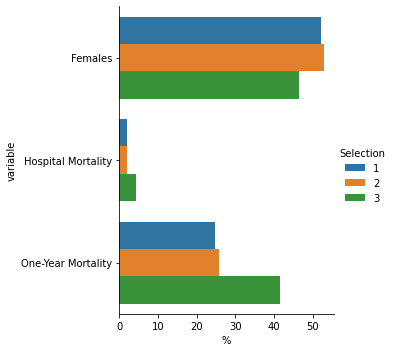

In [130]:
with sns.plotting_context(font_scale=2):
    plot = sns.catplot(data=cat, x='%', y='variable', hue='Selection', kind='bar')
    plot.savefig('consort_demo.pdf')

In [ ]:
with sns.plotting_context(font_scale=2):
    plot = sns.catplot(data=cat, x='%', y='variable', hue='Selection', kind='bar')
    plot.savefig('consort_demo.pdf')

In [142]:
cont[~mask]['mean'].mean()

5.3

In [143]:
cont[mask]['mean'].mean()

61.0

/tmp/ipykernel_26474/2501164889.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(np.round(ax1.get_yticks() / scale,1))


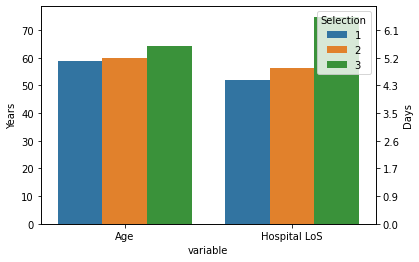

In [182]:
# Scale the data, just a simple example of how you might determine the scaling
cont_scaled = cont.copy()

mask = cont_scaled.variable == 'Hospital LoS'
scale = cont_scaled[~mask]['mean'].mean() / cont_scaled[mask]['mean'].mean()
cont_scaled.loc[mask, 'mean'] = cont_scaled.loc[mask, 'mean'] * scale
# cont_scaled.loc[mask, 'SD'] = cont_scaled.loc[mask, 'SD'] * scale

# Plot
fig, ax1 = plt.subplots()
g = sns.barplot(x="variable", y="mean", hue="Selection",
                data=cont_scaled, ax=ax1)

# x_coords = [p.get_x() + 0.5 * p.get_width() for p in g.patches]
# y_coords = [p.get_height() for p in g.patches]
# g.errorbar(x=x_coords, y=y_coords, 
#            yerr=cont_scaled["SD"], 
#            fmt="none", c="k")

# Create a second y-axis with the scaled ticks
ax1.set_ylabel('Years')
ax2 = ax1.twinx()

# Ensure ticks occur at the same positions, then modify labels
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticklabels(np.round(ax1.get_yticks() / scale,1))
ax2.set_ylabel('Days')

plt.show()
fig.savefig("consort_demo2.pdf")

### Observable Measurements (Prediction Target)

In [13]:
## NUMERIC FEATURES
## TODO: add mergers across tables and within-tables.

blood_gas = ['so2', 'po2', 'pco2', 'fio2', 'fio2_chartevents', 'aado2', 'aado2_calc', 'pao2fio2ratio', 'ph', 'baseexcess', 'bicarbonate', 'totalco2', 'hematocrit', 'hemoglobin', 'carboxyhemoglobin', 'methemoglobin', 'chloride', 'calcium', 'temperature', 'potassium', 'sodium', 'lactate', 'glucose']

blood_chemistry = ['albumin','globulin','total_protein','aniongap','bicarbonate','bun','calcium','chloride','creatinine','glucose','sodium','potassium']

cardiac_markers = ['troponin_t','ntprobnp','ck_mb']

cbc = ['hematocrit','hemoglobin','mch','mchc','mcv','platelet','rbc','rdw','wbc']

vital_signs = ['heart_rate','sbp','dbp','mbp','sbp_ni','dbp_ni','mbp_ni','resp_rate','temperature','spo2','glucose']

# Glasgow Coma Scale, a measure of neurological function
coma_signs = ['gcs','gcs_motor','gcs_verbal','gcs_eyes','gcs_unable']

renal_out = ['uo_rt_6hr', 'uo_rt_12hr', 'uo_rt_24hr']

renal_creat = ['creat']

renal_aki = ['aki_stage_smoothed']

In [14]:
def filter_measurements(df, hadm_id_selection=None, subject_id_selection=None):
    n = OrderedDict()
    n['n0'] = len(df)
    
    cols = df.columns
    
    # (1) Filter measurements based on admission_id selection.
    if hadm_id_selection is not None:
        df = df[df.hadm_id.isin(hadm_id_selection)]
    
    n['n adm. filter'] = len(df)
    
    
    # Merge with Admission Table
    df_ = df.merge(adm_df, on='hadm_id', how='left')

    # (2) Filter measurements based on subject_id selection
    if subject_id_selection is not None:
        df_ = df_[df_.subject_id.isin(subject_id_selection)]
    
    n['n subj. filter'] = len(df_)
        
    # (3) Filter measurements with time_bin outside the hosp stay.
    mask = df_.time_bin.between(df_.admittime, df_.dischtime)
    
    df_ = df_[mask]
    df = df_[cols]
    n['n in-patient time'] = len(df)
    
    print('\n'.join(f'{filt}: {num} ({100 * num / n["n0"]:.1f})' for filt, num in n.items()))
    print('\n========\n')
    return df

### Numeric Feature Tables

In [15]:
agg_interval = 'hour'
# For higher resolution binning see: 
# https://stackoverflow.com/questions/7299342/what-is-the-fastest-way-to-truncate-timestamps-to-5-minutes-in-postgres

# Time-binning can be specific for each table

In [16]:
renal_out_query = f"""
select icu.hadm_id,
       {', '.join(map(lambda e: f'avg(r.{e}) as {e}', renal_out))},
       date_trunc('{agg_interval}', r.charttime) time_bin
from mimiciv_derived.kdigo_uo as r
inner join mimiciv_icu.icustays as icu
 on icu.stay_id = r.stay_id
group by icu.hadm_id, time_bin
"""

renal_creat_query = f"""
select icu.hadm_id,
       {', '.join(map(lambda e: f'avg(r.{e}) as {e}', renal_creat))},
       date_trunc('{agg_interval}', r.charttime) time_bin
from mimiciv_derived.kdigo_creatinine as r
inner join mimiciv_icu.icustays as icu
 on icu.stay_id = r.stay_id
group by icu.hadm_id, time_bin
"""

renal_aki_query = f"""
select icu.hadm_id,
       {', '.join(map(lambda e: f'avg(r.{e}) as {e}', renal_aki))},
       date_trunc('{agg_interval}', r.charttime) time_bin
from mimiciv_derived.kdigo_stages as r
inner join mimiciv_icu.icustays as icu
 on icu.stay_id = r.stay_id
group by icu.hadm_id, time_bin
"""

renal_out_df = pd.read_sql_query(renal_out_query, con)
renal_creat_df = pd.read_sql_query(renal_creat_query, con)
renal_aki_df = pd.read_sql_query(renal_aki_query, con)


/tmp/ipykernel_243144/3420490817.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  renal_out_df = pd.read_sql_query(renal_out_query, con)
/tmp/ipykernel_243144/3420490817.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  renal_creat_df = pd.read_sql_query(renal_creat_query, con)
/tmp/ipykernel_243144/3420490817.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  renal_aki_df = pd.read_sql_query(renal_aki_query, con)


In [17]:
renal_aki_df.aki_stage_smoothed.max()

3.0

In [18]:
renal_hadm_id = pd.Series(renal_aki_df.hadm_id.unique())

In [19]:
adm_df['adm_has_renal_data'] = adm_df.hadm_id.isin(renal_hadm_id)
adm_df




,subject_id,hadm_id,admittime,dischtime,adm_has_renal_data
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,False
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,False
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,False
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,True
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,False
...,...,...,...,...,...
431226,19999828,25744818,2149-01-08 16:44:00,2149-01-18 17:00:00,True
431227,19999828,29734428,2147-07-18 16:23:00,2147-08-04 18:10:00,False
431228,19999840,21033226,2164-09-10 13:47:00,2164-09-17 13:42:00,True
431229,19999840,26071774,2164-07-25 00:27:00,2164-07-28 12:15:00,False


In [20]:
subject_has_renal = adm_df.groupby('subject_id', as_index=False).agg(n_adm=('hadm_id', 'nunique'), adm_has_renal_data=('adm_has_renal_data', 'sum'))
subjects_with_renal_info = subject_has_renal[subject_has_renal['adm_has_renal_data'] > 0]
subjects_with_renal_info['p_adm_with_renal_info'] = subjects_with_renal_info['adm_has_renal_data'] / subjects_with_renal_info['n_adm']
subject_id_with_renal_info = subjects_with_renal_info.subject_id
# subjects_with_renal_info['p_adm_with_renal_info'].hist()

/tmp/ipykernel_243144/2440518339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_with_renal_info['p_adm_with_renal_info'] = subjects_with_renal_info['adm_has_renal_data'] / subjects_with_renal_info['n_adm']


In [21]:
adm_df.subject_id.nunique()

180733

In [22]:
subject_id_with_renal_info

0         10000032
16        10000980
19        10001217
27        10001725
31        10001884
            ...   
180723    19999442
180727    19999625
180730    19999828
180731    19999840
180732    19999987
Name: subject_id, Length: 50920, dtype: int64

In [23]:
renal_out_df = filter_measurements(renal_out_df, hadm_id_selection=hadm_id_los_geq_12h, 
                                   subject_id_selection=subject_id_with_renal_info)
renal_creat_df = filter_measurements(renal_creat_df, hadm_id_selection=hadm_id_los_geq_12h, 
                                     subject_id_selection=subject_id_with_renal_info)
renal_aki_df = filter_measurements(renal_aki_df, hadm_id_selection=hadm_id_los_geq_12h, 
                                   subject_id_selection=subject_id_with_renal_info)

n0: 3294878 (100.0)
n adm. filter: 3292534 (99.9)
n subj. filter: 3292534 (99.9)
n in-patient time: 3285718 (99.7)


n0: 568158 (100.0)
n adm. filter: 566564 (99.7)
n subj. filter: 566564 (99.7)
n in-patient time: 502249 (88.4)


n0: 3687859 (100.0)
n adm. filter: 3684212 (99.9)
n subj. filter: 3684212 (99.9)
n in-patient time: 3613898 (98.0)




In [24]:
sofa_query = f"""
select hadm_id,
      avg(s.sofa_24hours) as sofa ,
      date_trunc('{agg_interval}', s.endtime) time_bin
from mimiciv_derived.sofa as s
inner join mimiciv_icu.icustays icu on s.stay_id = icu.stay_id
group by hadm_id, time_bin
"""

sofa_df = pd.read_sql_query(sofa_query,con)

/tmp/ipykernel_243144/1889668532.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sofa_df = pd.read_sql_query(sofa_query,con)


In [25]:
sofa_df = filter_measurements(sofa_df, hadm_id_selection=hadm_id_los_geq_12h, 
                            subject_id_selection=subject_id_with_renal_info)

n0: 6044160 (100.0)
n adm. filter: 6037941 (99.9)
n subj. filter: 6037941 (99.9)
n in-patient time: 6001782 (99.3)




In [26]:
blood_gas_query = f"""
select hadm_id,
       {', '.join(map(lambda e: f'avg(bg.{e}) as {e}', blood_gas))},
       date_trunc('{agg_interval}', bg.charttime) time_bin
from mimiciv_derived.bg as bg
where hadm_id is not null
group by hadm_id, time_bin
"""

bg_df = pd.read_sql_query(blood_gas_query,con)

/tmp/ipykernel_243144/2675251452.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bg_df = pd.read_sql_query(blood_gas_query,con)


In [27]:
bg_df = filter_measurements(bg_df, hadm_id_selection=hadm_id_los_geq_12h, 
                            subject_id_selection=subject_id_with_renal_info)

n0: 443301 (100.0)
n adm. filter: 442007 (99.7)
n subj. filter: 409545 (92.4)
n in-patient time: 404226 (91.2)




In [28]:
blood_chemistry_query = f"""
select hadm_id,
       {', '.join(map(lambda e: f'avg(ch.{e}) as {e}', blood_chemistry))},
       date_trunc('{agg_interval}', ch.charttime) time_bin
from mimiciv_derived.chemistry as ch
where hadm_id is not null
group by hadm_id, time_bin
"""

ch_df = pd.read_sql_query(blood_chemistry_query,con)

/tmp/ipykernel_243144/1787413314.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ch_df = pd.read_sql_query(blood_chemistry_query,con)


In [29]:
ch_df.dtypes

hadm_id                   int64
albumin                 float64
globulin                float64
total_protein           float64
aniongap                float64
bicarbonate             float64
bun                     float64
calcium                 float64
chloride                float64
creatinine              float64
glucose                 float64
sodium                  float64
potassium               float64
time_bin         datetime64[ns]
dtype: object

In [30]:
ch_df = filter_measurements(ch_df, hadm_id_selection=hadm_id_los_geq_12h, 
                            subject_id_selection=subject_id_with_renal_info)

n0: 1995534 (100.0)
n adm. filter: 1987259 (99.6)
n subj. filter: 1334968 (66.9)
n in-patient time: 1313463 (65.8)




In [ ]:
cardiac_marker_query = \
f"""
WITH trop AS
(
    SELECT specimen_id, MAX(valuenum) AS troponin_t
    FROM mimiciv_hosp.labevents
    WHERE itemid = 51003
    GROUP BY specimen_id
)
SELECT
    c.hadm_id
    , date_trunc('{agg_interval}', c.charttime) time_bin
    , avg(trop.troponin_t) as troponin_t
    , avg(c.ntprobnp) as ntprobnp
    , avg(c.ck_mb) as ck_mb
FROM mimiciv_hosp.admissions a
LEFT JOIN mimiciv_derived.cardiac_marker c
  ON a.hadm_id = c.hadm_id
LEFT JOIN trop
  ON c.specimen_id = trop.specimen_id
WHERE c.hadm_id is not null
GROUP BY c.hadm_id, time_bin
"""

cardiac_df = pd.read_sql_query(cardiac_marker_query,con)

/tmp/ipykernel_243144/2989961123.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cardiac_df = pd.read_sql_query(cardiac_marker_query,con)


In [ ]:
cardiac_df.dtypes

In [ ]:
cardiac_df = filter_measurements(cardiac_df, hadm_id_selection=hadm_id_los_geq_12h, 
                                 subject_id_selection=subject_id_with_renal_info)

In [ ]:
temp_query = \
f"""
WITH temp_t AS (
    SELECT c.hadm_id
        , c.charttime
        , CASE
            WHEN LOWER(c.valueuom)  like '%°f%' THEN (c.valuenum - 32) / 1.8
                ELSE c.valuenum
          END AS temperature
    FROM mimiciv_hosp.admissions a
    INNER JOIN mimiciv_icu.chartevents c
      ON a.hadm_id = c.hadm_id
    INNER JOIN mimiciv_icu.d_items di
      ON c.itemid = di.itemid
    AND c.itemid IN
    (
    227632, -- Arctic Sun/Alsius Temp #1 C
    227634, -- Arctic Sun/Alsius Temp #2 C
    223761 -- Temperature Fahrenheit
    )
    AND valuenum > 10 AND valuenum < 120
)
SELECT temp_t.hadm_id
     , AVG(temp_t.temperature) temperature
     , DATE_TRUNC('{agg_interval}', temp_t.charttime) time_bin
FROM temp_t
GROUP BY temp_t.hadm_id, time_bin
"""
temp_df = pd.read_sql_query(temp_query,con)

In [ ]:
temp_df = filter_measurements(temp_df, hadm_id_selection=hadm_id_los_geq_12h, 
                              subject_id_selection=subject_id_with_renal_info)

In [ ]:
weight_query = f"""
select icu.hadm_id,
     avg(w.weight) weight,
        w.time_bin
 from (
 (select stay_id, w.weight, date_trunc('{agg_interval}', w.starttime) time_bin
  from mimiciv_derived.weight_durations as w)
 union all
 (select stay_id, w.weight, date_trunc('{agg_interval}', w.endtime) time_bin
     from mimiciv_derived.weight_durations as w)
 ) w
inner join mimiciv_icu.icustays icu on w.stay_id = icu.stay_id
group by icu.hadm_id, w.time_bin
"""

weight_df = pd.read_sql_query(weight_query,con)

In [ ]:
weight_df = filter_measurements(weight_df, hadm_id_selection=hadm_id_los_geq_12h, 
                                subject_id_selection=subject_id_with_renal_info)

In [ ]:
cbc_query = f"""
select hadm_id,
       {', '.join(map(lambda e: f'avg(cbc.{e}) as {e}', cbc))},
       date_trunc('{agg_interval}', cbc.charttime) time_bin
from mimiciv_derived.complete_blood_count as cbc
where hadm_id is not null
group by hadm_id, time_bin
"""
cbc_df = pd.read_sql_query(cbc_query, con)

In [ ]:
cbc_df.dtypes

In [ ]:
cbc_df = filter_measurements(cbc_df, hadm_id_selection=hadm_id_los_geq_12h, 
                             subject_id_selection=subject_id_with_renal_info)

In [ ]:
vital_query = f"""
select icu.hadm_id,
       {', '.join(map(lambda e: f'avg(v.{e}) as {e}', vital_signs))},
       date_trunc('{agg_interval}', v.charttime) time_bin
from mimiciv_derived.vitalsign as v
inner join mimiciv_icu.icustays as icu
 on icu.stay_id = v.stay_id
group by icu.hadm_id, time_bin
"""
vital_df = pd.read_sql_query(vital_query, con)

In [ ]:
vital_df = filter_measurements(vital_df, hadm_id_selection=hadm_id_los_geq_12h, 
                               subject_id_selection=subject_id_with_renal_info)

In [ ]:
gcs_query = f"""
select icu.hadm_id,
       {', '.join(map(lambda e: f'avg(gcs.{e}) as {e}', coma_signs))},
       date_trunc('{agg_interval}', gcs.charttime) time_bin
from mimiciv_derived.gcs as gcs
inner join mimiciv_icu.icustays as icu
 on icu.stay_id = gcs.stay_id
group by icu.hadm_id, time_bin
"""
gcs_df = pd.read_sql_query(gcs_query, con)

In [ ]:
gcs_df = filter_measurements(gcs_df, hadm_id_selection=hadm_id_los_geq_12h, 
                             subject_id_selection=subject_id_with_renal_info)

In [ ]:
obs_tables = {'blood_gas': bg_df,
             'chemistry': ch_df,
             'cardiac_marker': cardiac_df,
             'temperature': temp_df,
             'weight': weight_df,
             'cbc': cbc_df,
             'vital': vital_df,
             'gcs': gcs_df,
             'renal_out': renal_out_df,
             'renal_creat': renal_creat_df,
             'renal_aki': renal_aki_df,
             'sofa': sofa_df}
obs_columns = {table_name: set(df.columns) - {'time_bin', 'hadm_id'} for table_name, df in obs_tables.items()}

In [ ]:
obs_group = {col: group for group, cols in obs_columns.items() for col in cols}
obs_codes = pd.DataFrame({'label': sorted(obs_group), 'group': map(obs_group.get, sorted(obs_group))})
obs_codes = obs_codes.sort_values(by='group').reset_index(drop=True)
obs_codes['code'] = obs_codes.index.map(lambda i: f'o{i:02d}')
code_map = dict(zip(obs_codes.label, obs_codes.code))

In [ ]:
obs_melted_tables = {k: pd.melt(df, id_vars=['hadm_id', 'time_bin'], 
                                var_name=['code'],
                                value_vars=obs_columns[k]) for k, df in
                    obs_tables.items()}

obs_melted_tables = {k: df[df.value.notnull()] for k, df in obs_melted_tables.items()}

In [ ]:
obs_df = pd.concat(obs_melted_tables.values(), axis=0)

In [ ]:
obs_df['code'] = obs_df['code'].map(code_map)
obs_df

In [ ]:
obs_df.to_csv('obs_df.csv.gz', compression='gzip')
obs_codes.to_csv('mimic4_obs_codes.csv.gz', compression='gzip')

In [ ]:
obs_codes

### Interventions



In [ ]:
## Inputs - Canonicalise

input_query = \
"""
SELECT
    a.hadm_id
    , inp.starttime as start_time
    , inp.endtime as end_time
    , di.label
    , inp.rate 
    , inp.amount
    , inp.rateuom
    , inp.amountuom
FROM mimiciv_hosp.admissions a
INNER JOIN mimiciv_icu.icustays i
    ON a.hadm_id = i.hadm_id
LEFT JOIN mimiciv_icu.inputevents inp
    ON i.stay_id = inp.stay_id
LEFT JOIN mimiciv_icu.d_items di
    ON inp.itemid = di.itemid
"""


## Procedures - Canonicalise and Refine
icuproc_query = \
"""
SELECT
    a.hadm_id
    , pe.starttime as start_time
    , pe.endtime as end_time
    , di.label
    , pe.value
FROM mimiciv_hosp.admissions a
INNER JOIN mimiciv_icu.icustays i
    ON a.hadm_id = i.hadm_id
LEFT JOIN mimiciv_icu.procedureevents pe
    ON i.stay_id = pe.stay_id
LEFT JOIN mimiciv_icu.d_items di
    ON pe.itemid = di.itemid
"""

hospicdproc_query = \
"""
select pi.hadm_id
, (pi.chartdate)::timestamp as start_time
, (pi.chartdate + interval '1 hour')::timestamp as end_time
, pi.icd_code
, pi.icd_version
, di.long_title
FROM mimiciv_hosp.procedures_icd pi
INNER JOIN mimiciv_hosp.d_icd_procedures di
  ON pi.icd_version = di.icd_version
  AND pi.icd_code = di.icd_code
INNER JOIN mimiciv_hosp.admissions a
  ON pi.hadm_id = a.hadm_id
"""


# === provider order entry (poe) <----- very messy, high irrelevance, ignore

poe_query = f"""
SELECT
    a.hadm_id
    , mimiciv_derived.DATETIME_DIFF(p.ordertime, a.admittime, 'DAY') AS offset
    , p.poe_id
    , p.order_type, p.order_subtype
    , p.transaction_type
    , pd.field_name
    , pd.field_value
FROM mimiciv_hosp.admissions a
INNER JOIN mimiciv_hosp.poe p
    ON a.hadm_id = p.hadm_id
LEFT JOIN  mimiciv_hosp.poe_detail pd
    ON p.poe_id = pd.poe_id
"""

In [ ]:
input_df = pd.read_sql_query(input_query,con)

In [ ]:
icuproc_df = pd.read_sql_query(icuproc_query,con)

In [ ]:
hospicdproc_df = pd.read_sql_query(hospicdproc_query,con)

In [ ]:
# Ignored entirely
# poe_df = pd.read_sql_query(poe_query,con)

In [ ]:
def filter_interventions(df, hadm_id_selection=None, subject_id_selection=None):
    n = OrderedDict()
    n['n0'] = len(df)
    
    cols = df.columns
    
    # (1) Filter interventions based on admission_id selection.
    if hadm_id_selection is not None:
        df = df[df.hadm_id.isin(hadm_id_selection)]
    
    n['n adm. filter'] = len(df)
    
    
    # Merge with Admission Table
    df_ = df.merge(adm_df, on='hadm_id', how='left')

    # (2) Filter interventions based on subject_id selection
    if subject_id_selection is not None:
        df_ = df_[df_.subject_id.isin(subject_id_selection)]
    
    n['n subj. filter'] = len(df_)
        
    # (3) Filter interventions with intervals outside the hosp stay.
    mask1 = df_.start_time.between(df_.admittime, df_.dischtime)
    mask2 = df_.end_time.between(df_.admittime, df_.dischtime)
    n['n start-time filter'] = sum(mask1)
    n['n end-time filter'] = sum(mask1 & mask2)

    df_ = df_[mask1 & mask2]    
    
    df = df_[cols]
    n['n in-patient time'] = len(df)
    
    print('\n'.join(f'{filt}: {num} ({100 * num / n["n0"]:.1f})' for filt, num in n.items()))
    print('\n========\n')
    return df

In [ ]:
input_df = filter_interventions(input_df, hadm_id_selection=hadm_id_los_geq_12h, 
                                subject_id_selection=subject_id_with_renal_info)

In [ ]:
input_df.label.nunique()

In [ ]:
icuproc_df = filter_interventions(icuproc_df, hadm_id_selection=hadm_id_los_geq_12h, 
                                subject_id_selection=subject_id_with_renal_info)

In [ ]:
hospicdproc_df = filter_interventions(hospicdproc_df, hadm_id_selection=hadm_id_los_geq_12h, 
                                subject_id_selection=subject_id_with_renal_info)

In [ ]:
hospicdproc_df

### `hospicdproc` + `icuproc` Further filteration and grouper

In [ ]:
df = hospicdproc_df.merge(adm_df, on='hadm_id', how='left')

# timeperc_within_stay = (df['start_time'] - df['admittime']).dt.total_seconds() /(df['dischtime'] - df['admittime']).dt.total_seconds()
# timeperc_within_stay.plot.kde()

In [ ]:
icd_n_subjects = df.groupby(['icd_code', 'long_title', 'icd_version'], as_index=False).agg(n_subjects=('subject_id', 'nunique'))
icd_n_subjects['p_subjects'] = icd_n_subjects['n_subjects'] / len(subject_id_with_renal_info)
# icd_n_subjects['p_subjects'].plot.kde()

In [ ]:
# Conisder ICD codes with minimum coverage of 0.5% of the selected subjects.
hospicd_R1 = icd_n_subjects[icd_n_subjects['p_subjects'] > 0.005]

# Remove procedures that are purely diagnostic.
patterns = ['diag', 'fluoro', 'biops', 'inspection', 'bronchoscop', 'monitor', 'ultrasonography']

hospicd_R2_mask = hospicd_R1['long_title'].str.match('|'.join(f'(.*{p}.*)' for p in patterns), case=False)
hospicd_R2 = hospicd_R1[~hospicd_R2_mask]


hospicd_R1.to_csv('hospicd_R1.csv')
hospicd_R2.to_csv('hospicd_R2.csv')

In [ ]:
# Apply filteration.
hospicdproc_df = hospicdproc_df[hospicdproc_df.icd_code.isin(hospicd_R2.icd_code)]

In [ ]:
df = hospicdproc_df.merge(adm_df, on='hadm_id', how='left')

# timeperc_within_stay = (df['start_time'] - df['admittime']).dt.total_seconds() /(df['dischtime'] - df['admittime']).dt.total_seconds()
# timeperc_within_stay.plot.kde(bw_method=0.05)

In [ ]:
icd_n_subjects = df.groupby(['icd_code', 'long_title', 'icd_version'], as_index=False).agg(n_subjects=('subject_id', 'nunique'))
icd_n_subjects['p_subjects'] = icd_n_subjects['n_subjects'] / len(subject_id_with_renal_info)
# icd_n_subjects['p_subjects'].plot.kde(bw_method=0.01)

In [ ]:
hospicdproc_df

In [ ]:
hospicdproc_grouper = pd.read_csv('int_grouper_hospicdproc.csv')
hospicdproc_grouper

In [ ]:
n1 = len(hospicdproc_df)
icd_selection = set(hospicdproc_grouper.icd_code)
print(hospicdproc_grouper.icd_code.nunique(), len(hospicdproc_grouper))



In [ ]:
hospicdproc_df = hospicdproc_df[hospicdproc_df.icd_code.isin(icd_selection)]
n2 = len(hospicdproc_df)
n1, n2

#### Standard Procedure Table

In [ ]:
hospicd_coder = lambda v, c: f"v{v}:c{c}"

hospicdproc_df["code"] = list(map(hospicd_coder, hospicdproc_df["icd_version"], hospicdproc_df["icd_code"]))
hospicdproc_grouper["code"] = list(map(hospicd_coder, hospicdproc_grouper["icd_version"], hospicdproc_grouper["icd_code"]))
hospicdproc_grouper["label"] = hospicdproc_grouper["long_title"]

hospicdproc_df = hospicdproc_df[["hadm_id", "start_time", "end_time", "code"]]
hospicdproc_grouper = hospicdproc_grouper[["code", "group", "label"]]

### 'icuproc` refinement

In [ ]:
icuproc_df

In [ ]:
icuproc_df['total_interval_hrs'] = (icuproc_df['end_time'] - icuproc_df['start_time']).dt.total_seconds() / 3600
icuproc_df['total_interval_mins'] = (icuproc_df['end_time'] - icuproc_df['start_time']).dt.total_seconds() / 60
icuproc_df['value_per_hour'] = icuproc_df['value'] / icuproc_df['total_interval_hrs']

df = icuproc_df.merge(adm_df, on='hadm_id', how='left')
df['count'] = 1

In [ ]:
icuproc_n_subjects = df.groupby('label', as_index=False).agg(
    n_subjects=('subject_id', 'nunique'),
    n=('count', 'sum'),
    mean_value=('value', 'mean'),
    std_value=('value', 'std'),
    mean_value_per_hour=('value_per_hour', 'mean'),
    std_value_per_hour=('value_per_hour', 'std'),
    mean_interval_minutes=('total_interval_mins', 'mean'),
    std_interval_minutes=('total_interval_mins', 'std'))
    

In [ ]:
icuproc_n_subjects.to_csv('icuproc_n_subjects.csv')

In [ ]:
int_icuproc_grouper = pd.read_csv('int_grouper_icuproc.csv')

In [ ]:
n1 = len(icuproc_df)
exclude_icuproc = set(int_icuproc_grouper[int_icuproc_grouper.group == 'exclude'].label)

icuproc_df = icuproc_df[~icuproc_df.label.isin(exclude_icuproc)]
n2 = len(icuproc_df)
n1, n2

#### Standard Procedure Table

In [ ]:
icuproc_df["code"] = icuproc_df["label"]
int_icuproc_grouper["code"] = int_icuproc_grouper["label"]
int_icuproc_grouper["label"] = int_icuproc_grouper["label"]

icuproc_df = icuproc_df[["hadm_id", "start_time", "end_time", "code"]]
int_icuproc_grouper = int_icuproc_grouper[["code", "group", "label"]]

In [ ]:
int_proc_df = pd.concat([hospicdproc_df, icuproc_df], axis=0)
int_grouper_proc = pd.concat([hospicdproc_grouper, int_icuproc_grouper], axis=0)

int_proc_df.to_csv('int_proc.csv.gz', compression='gzip')
int_grouper_proc.to_csv('mimic4_int_grouper_proc.csv.gz', compression='gzip')

In [ ]:
int_grouper_proc2 = int_grouper_proc.set_index(['group', 'code']).sort_index()
with pd.ExcelWriter('int_grouper_proc2.xlsx') as writer:
    int_grouper_proc2.to_excel(writer, sheet_name='Sheet1', merge_cells = True)

In [ ]:
int_grouper_proc

### `input` filteration and refinement

In [ ]:
input_df['total_interval_hrs'] = (input_df['end_time'] - input_df['start_time']).dt.total_seconds() / 3600
input_df['total_interval_mins'] = (input_df['end_time'] - input_df['start_time']).dt.total_seconds() / 60
input_df['amount_per_hour'] = input_df['amount'] / input_df['total_interval_hrs']

In [ ]:
df = input_df.merge(adm_df, on='hadm_id', how='left')
df['count'] = 1

In [ ]:
input_n_subjects = df.groupby(['label', 'amountuom'], as_index=False).agg(
    n_subjects=('subject_id', 'nunique'),
    n=('count', 'sum'),
    mean_amount=('amount', 'mean'),
    std_amount=('amount', 'std'),
    mean_amount_per_hour=('amount_per_hour', 'mean'),
    std_amount_per_hour=('amount_per_hour', 'std'),
    mean_interval_minutes=('total_interval_mins', 'mean'),
    std_interval_minutes=('total_interval_mins', 'std'))
    

In [ ]:
input_n_subjects.to_csv('input_n_subjects.csv')


In [ ]:
"""
from IPython.display import display

input_n_subjects_tom = pd.read_csv('input_n_subjects_tom.csv', index_col=[0])
# Change 'M' (maybe) to 'Y' (yes)
input_n_subjects_tom.loc[input_n_subjects_tom['dose_impact'] == 'M', 'dose_impact'] = 'Y'

# Add column for unit normalisation, default=1.0
input_n_subjects_tom['rate_normaliser'] = 1.0

# Add label groups
input_n_subjects_tom['group'] = input_n_subjects_tom.label.map(input_group_map)

# Default group decision:

init_decision = {}
for group, group_df in input_n_subjects_tom.groupby('group'):
    dose_impact = list(group_df['dose_impact'].unique())
    
    assert len(dose_impact) == 1, f"Incosistant dose impact decision {group}."
    dose_impact = dose_impact[0]
    if dose_impact == 'Y':
        if group_df.label.nunique() > 1:
            if group_df.amountuom.nunique() > 1:
                init_decision[group] = 'DS(or DH, norm)'
            else:
                init_decision[group] = 'DS(or DH)'
        else:
            if group_df.amountuom.nunique() > 1:
                init_decision[group] = 'DH(norm)'
            else:
                init_decision[group] = 'DH'
    elif dose_impact == 'N':
        
        if group_df.label.nunique() > 1:
            init_decision[group] = 'H(or S)'
        else:
            init_decision[group] = 'H'
    else:
        init_decision[group] = 'E'

input_n_subjects_tom['group_decision'] = input_n_subjects_tom['group'].map(init_decision)

# Change the order of rate_normaliser column
input_n_subjects_tom.insert(1, 'rate_normaliser', input_n_subjects_tom.pop('rate_normaliser'))

input_n_subjects_tom = input_n_subjects_tom.set_index(['group', 'dose_impact', 'group_decision', 'label', 'amountuom'])
"""

In [ ]:
"""
with pd.ExcelWriter('input_label_groups_notes.xlsx') as writer:
    input_n_subjects_tom.to_excel(writer, sheet_name='Sheet1', merge_cells = True)
"""

In [82]:
int_grouper_input_df = pd.read_excel('input_label_groups_decisions.xlsx').fillna(method='ffill')

In [112]:
int_grouper_input_df

,group,dose_impact,group_decision,label,amountuom,rate_normaliser,n_subjects,n,mean_amount,std_amount,mean_amount_per_hour,std_amount_per_hour,mean_interval_minutes,std_interval_minutes,p_subjects,comment,Unnamed: 16
0,ACD-A Citrate,Y,sum,ACD-A Citrate (1000ml),ml,1.0,1331,30619,871.476773,267.588827,188.309053,55.513516,288.599922,110.159569,0.026139,NaN,NaN
1,ACD-A Citrate,Y,sum,ACD-A Citrate (500ml),ml,1.0,32,585,631.250567,271.469905,181.065294,64.394169,214.500855,89.981564,0.000628,NaN,NaN
2,Abciximab,N,or,Abciximab (Reopro),mg,1.0,7,7,5.043947,2.518941,0.681447,0.117999,470.142857,272.331556,0.000137,NaN,NaN
3,Acetaminophen-IV,N,or,Acetaminophen-IV,dose,1.0,6,6,1.000000,0.000000,60.000000,0.000000,1.000000,0.000000,0.000118,NaN,NaN
4,Acetaminophen-IV,N,or,Acetaminophen-IV,grams,1.0,22,41,1.000000,0.000000,60.000000,0.000000,1.000000,0.000000,0.000432,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,XXXfloxacin,N,or,Levofloxacin,dose,1.0,2418,5490,1.454645,17.824212,87.278689,1069.452720,1.000000,0.000000,0.047486,Oral,the mean suggests pL = L and not the picoL
471,XXXfloxacin,N,or,Levofloxacin,grams,1.0,1,1,750.000000,17.824212,45000.000000,1069.452720,1.000000,0.000000,0.000020,Oral,the mean suggests pL = L and not the picoL
472,XXXfloxacin,N,or,Levofloxacin,mg,1.0,94,110,667.727317,151.685715,40063.639023,9101.142894,1.000000,0.000000,0.001846,Oral,the mean suggests pL = L and not the picoL
473,XXXfloxacin,N,or,Moxifloxacin,dose,1.0,7,22,1.000000,0.000000,60.000000,0.000000,1.000000,0.000000,0.000137,Oral,the mean suggests pL = L and not the picoL


In [117]:
int_grouper_input_df.group_decision.unique()

array(['sum', 'or', 'w_sum', 'E'], dtype=object)

In [84]:
int_grouper_input_df.to_csv('mimic4_int_grouper_input.csv.gz', compression='gzip')

#### Normalise rates of different units for the same input item

In [107]:
rate_scaler = dict(zip(map(lambda c1, c2: f'{c1}-{c2}', int_grouper_input_df.label, int_grouper_input_df.amountuom), int_grouper_input_df.rate_normaliser))

input_df['label-uom'] = list(map(lambda c1, c2: f'{c1}-{c2}', input_df.label, input_df.amountuom))
input_df['normalised_amount_per_hour'] = input_df['amount_per_hour'] * input_df['label-uom'].map(rate_scaler)

In [110]:
input_df = input_df[['hadm_id', 'start_time', 'end_time', 'label', 'normalised_amount_per_hour']]

In [111]:
input_df.to_csv('int_input.csv.gz', compression='gzip')

In [115]:
input_df

,hadm_id,start_time,end_time,label,normalised_amount_per_hour
0,29079034,2180-07-23 21:10:00,2180-07-23 21:11:00,PO Intake,6.000000
1,29079034,2180-07-23 17:00:00,2180-07-23 17:01:00,PO Intake,12.000000
2,29079034,2180-07-23 17:00:00,2180-07-23 17:30:00,Albumin 25%,99.999998
3,29079034,2180-07-23 17:33:00,2180-07-23 18:03:00,Albumin 25%,99.999998
4,29079034,2180-07-23 18:56:00,2180-07-23 18:57:00,PO Intake,6.000000
...,...,...,...,...,...
8961335,23865745,2145-11-02 23:28:00,2145-11-03 09:32:00,Fentanyl (Concentrate),0.075000
8961336,23865745,2145-11-02 23:28:00,2145-11-03 09:32:00,Solution,1.500000
8961337,23865745,2145-11-02 23:38:00,2145-11-03 12:55:00,NaCl 0.9%,0.075282
8961338,23865745,2145-11-04 20:35:00,2145-11-04 20:36:00,PO Intake,12.000000


## Dx Codes Filteration

In [87]:
def filter_discharge_codes(df, subject_id_selection=None):
    n = OrderedDict()
    n['n0'] = len(df)
    
    cols = df.columns
    
    # (1) Filter discharge codes if subject has a single admission.
    n_adms = df.groupby('subject_id', as_index=False).agg(n_adms=('hadm_id', 'nunique'))
    n_adms_subjects = set(n_adms[n_adms['n_adms'] > 1].subject_id)
    df = df[df.subject_id.isin(n_adms_subjects)]
    
    n['n adm. > 1 filter'] = len(df)
    

    # (2) Filter discharge dx codes based on subject_id selection
    if subject_id_selection is not None:
        df = df[df.subject_id.isin(subject_id_selection)]
    
    n['n subj. filter'] = len(df)
        
    
    print('\n'.join(f'{filt}: {num} ({100 * num / n["n0"]:.1f})' for filt, num in n.items()))
    print('\n========\n')
    return df

In [88]:
dx_query = f"""
SELECT
    hadm_id, subject_id, icd_code, icd_version
FROM mimiciv_hosp.diagnoses_icd 
"""
dx_df = pd.read_sql_query(dx_query,con)

In [89]:
dx_df = filter_discharge_codes(dx_df, subject_id_selection=subject_id_with_renal_info)

n0: 4756326 (100.0)
n adm. > 1 filter: 3857079 (81.1)
n subj. filter: 2194672 (46.1)




In [90]:
dx_df

,hadm_id,subject_id,icd_code,icd_version
0,22595853,10000032,5723,9
1,22595853,10000032,78959,9
2,22595853,10000032,5715,9
3,22595853,10000032,07070,9
4,22595853,10000032,496,9
...,...,...,...,...
4756310,26071774,19999840,34590,9
4756311,26071774,19999840,43811,9
4756312,26071774,19999840,4019,9
4756313,26071774,19999840,2724,9


In [91]:
dx_df.to_csv('dx_df.csv.gz', compression='gzip')

## Admissions & Static Tables 

In [92]:
def filter_admissions(df, subject_id_selection=None):
    n = OrderedDict()
    n['n0'] = len(df)
    
    cols = df.columns

    # (1) Filter discharge dx codes based on subject_id selection
    if subject_id_selection is not None:
        df = df[df.subject_id.isin(subject_id_selection)]
    
    n['n subj. filter'] = len(df)
        
    
    print('\n'.join(f'{filt}: {num} ({100 * num / n["n0"]:.1f})' for filt, num in n.items()))
    print('\n========\n')
    return df

In [93]:
adm_query = f"""
SELECT
    hadm_id, subject_id, admittime, dischtime, race
FROM mimiciv_hosp.admissions 
"""
adm_df = pd.read_sql_query(adm_query,con)

In [94]:
static_query = f"""
SELECT 
    p.subject_id, p.gender, a.race, p.anchor_age, p.anchor_year
    from mimiciv_hosp.patients p
    left join 
    (select subject_id, max(race) as race
    from mimiciv_hosp.admissions
    group by subject_id) as a
    on p.subject_id = a.subject_id
"""
static_df = pd.read_sql_query(static_query,con)

In [95]:
adm_df = filter_admissions(adm_df, subject_id_selection=subject_id_with_renal_info)
static_df = filter_admissions(static_df, subject_id_selection=subject_id_with_renal_info)


n0: 431231 (100.0)
n subj. filter: 174899 (40.6)


n0: 299712 (100.0)
n subj. filter: 50920 (17.0)




In [96]:
adm_df.to_csv('adm_df.csv.gz', compression='gzip')
static_df.to_csv('static_df.csv.gz', compression='gzip')

In [97]:

# static_df.groupby('race', as_index=False).agg(n=('subject_id', 'count')).to_csv('race_groups.csv', compression='gzip')
race_groups_df = pd.read_csv('race_grouper.csv', index_col=0)

In [98]:
race_groups_df.to_csv('mimic4_race_grouper.csv.gz', compression='gzip')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from lib.ehr.coding_scheme import MIMIC4Observables
C = MIMIC4Observables()

z_min = -2.5
z_max = -z_min
q_min = 0.1
q_max = 1 - q_min

for code in sorted(m4inpatient_dataset.df['obs'].code.unique()):
    df = m4inpatient_dataset.df['obs']
    code_df = df[df.code == code]
    
    q1 = code_df.value.quantile(q_min)
    q2 = code_df.value.quantile(q_max)
    qin_mask = code_df.value.between(q1, q2)

    mu = code_df.value.mean()
    std = code_df.value.std()
    code_df['z'] = (code_df.value - mu) / std
    x1 = mu + z_min * std
    x2 = mu + z_max * std

    zin_mask = code_df.z.between(z_min, z_max)

    

    textstr = '\n'.join((
        f'n={len(code_df)}',
        f'(min, max): ({code_df.value.min():0.2f}, {code_df.value.max():0.2f})',
        f'p(qin): {qin_mask.mean():0.3f}',
        f'p(zin): {zin_mask.mean():0.3f}',
        f'p(zin or qin): {(qin_mask | zin_mask).mean(): 0.3f}'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    
    g = sns.displot(code_df, x="value", kde=True)

    for ax in g.axes.flat:
        args = zip([x1, x2, q1, q2], 
                   ["solid", "solid", "dashed", "dashed"], 
                   ["red", "red", "red", "red"])
        ax.set_title(C.desc[code])
            # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
        for x, style, color in args:            
            ax.axvline(x=x, ymin = 0, ymax = 1.0, linestyle=style, color=color)
    g.savefig(f"obs_outlier__{code}_{C.desc[code]}.pdf", bbox_inches='tight')